(-0.5, 1662.5, 1246.5, -0.5)

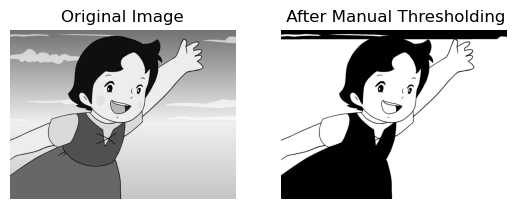

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(r"C:\Users\hanal\Downloads\heidi_01.jpg") 
df=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

threshold_value = 127  
max_value = 255     
img= np.zeros_like(df)   
img[df >= threshold_value] = max_value  

plt.subplot(121)
plt.imshow(df,cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(img,cmap='gray')
plt.title(' After Manual Thresholding')
plt.axis('off')

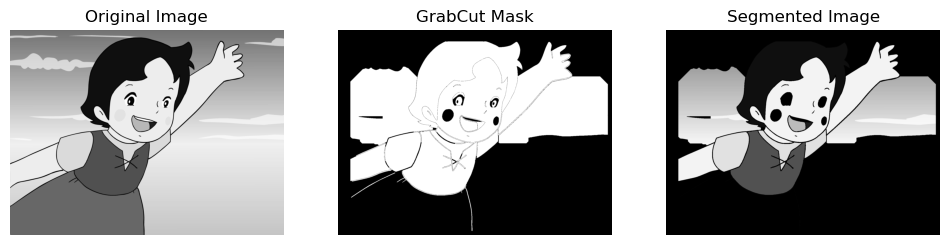

In [16]:
image = cv2.imread(r"C:\Users\hanal\Downloads\heidi_01.jpg") 

# Step 2: Create a mask for grabCut
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Step 3: Define the rectangle around the region of interest (ROI)
# Format: (x, y, width, height)
rect = (75, 75, image.shape[1] - 100, image.shape[0] - 100)  # Adjust rectangle as needed

# Step 4: Initialize foreground and background models
bgd_model = np.zeros((1, 65), dtype=np.float64)  # Background model
fgd_model = np.zeros((1, 65), dtype=np.float64)  # Foreground model

# Step 5: Apply grabCut algorithm
cv2.grabCut(image, mask, rect, bgd_model, fgd_model, iterCount=5, mode=cv2.GC_INIT_WITH_RECT)

# Step 6: Modify mask to extract foreground
mask_2 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
segmented_image = cv2.bitwise_and(df, df, mask=mask_2)

# Step 7: Display results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(df,cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Masked Image
plt.subplot(1, 3, 2)
plt.imshow(mask_2, cmap='gray')
plt.title('GrabCut Mask')
plt.axis('off')

# Segmented Image
plt.subplot(1, 3, 3)
plt.imshow(segmented_image,cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.show()


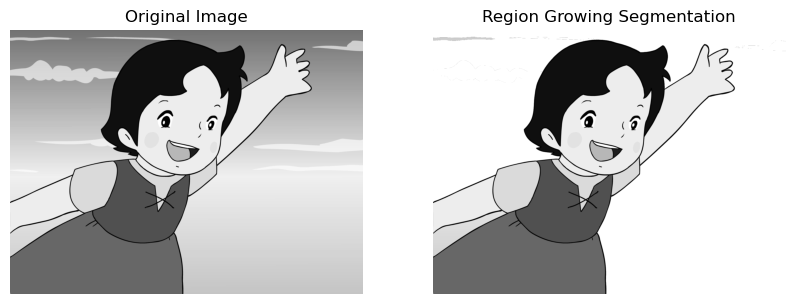

In [13]:

# Define seed point and threshold values
seed_point = (100, 100)  # Change as needed (x, y)
lo_diff = 15  # Lower intensity difference threshold
up_diff = 15  # Upper intensity difference threshold

# Create a mask for floodFill (must be larger than the image)
height, width = df.shape
mask = np.zeros((height + 2, width + 2), dtype=np.uint8)  # Mask size must be (image size + 2)

# Apply floodFill for region growing
flood_fill_image = df.copy()
cv2.floodFill(flood_fill_image, mask, seed_point, newVal=255, loDiff=lo_diff, upDiff=up_diff)

# Display original and segmented images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(df, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(flood_fill_image, cmap='gray')
plt.title('Region Growing Segmentation')
plt.axis('off')

plt.show()


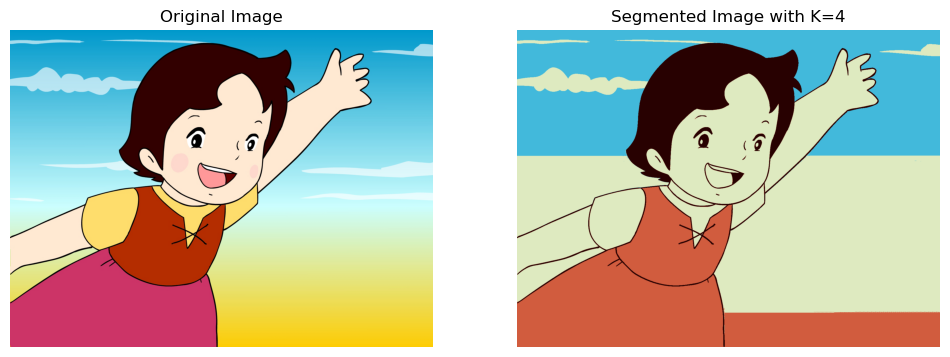

In [10]:


def initialize_centroids(X, k):
    """Randomly initialize centroids from the dataset."""
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    """Assign each data point to the nearest centroid."""
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)  # Calculate distances
    return np.argmin(distances, axis=1)  # Assign clusters based on closest centroid

def update_centroids(X, labels, k):
    """Update centroids to be the mean of the assigned clusters."""
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def kmeans(X, k, max_iters=100, tol=1e-4):
    """Perform K-means clustering."""
    centroids = initialize_centroids(X, k)
    
    for _ in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        
        # Check for convergence (if centroids do not change)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        
        centroids = new_centroids

    return labels, centroids

# Load the image
image_path = r"C:\Users\hanal\Downloads\heidi_01.jpg"  # Replace with your image path
image = cv2.imread(image_path)
if image is None:
    print("Error: Unable to load image. Check file path.")
    exit()

# Convert image to RGB and reshape it for clustering
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_values = image_rgb.reshape((-1, 3))  # Flatten the image into a 2D array (pixels x RGB)

# Perform K-means clustering
k = 4  # Number of clusters
labels, centroids = kmeans(pixel_values.astype(float), k)

# Create segmented image based on labels
segmented_image = centroids[labels].reshape(image_rgb.shape).astype(np.uint8)

# Display original and segmented images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title(f'Segmented Image with K={k}')
plt.axis('off')

plt.show()


In [ ]:


class MeanShiftSegmentation:
    def __init__(self, radius=10, max_iter=100):
        self.radius = radius
        self.max_iter = max_iter

    def fit(self, image):
        # Reshape the image to be a list of pixels
        pixel_values = image.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        # Initialize cluster centers as the pixel values
        centroids = pixel_values.copy()

        for _ in range(self.max_iter):
            new_centroids = []
            for centroid in centroids:
                # Find all points within the radius of the centroid
                distances = np.linalg.norm(pixel_values - centroid, axis=1)
                in_bandwidth = pixel_values[distances < self.radius]

                # Calculate the new centroid as the mean of these points
                if len(in_bandwidth) > 0:
                    new_centroid = np.mean(in_bandwidth, axis=0)
                    new_centroids.append(new_centroid)

            # Remove duplicates by converting to a set of tuples and back to an array
            new_centroids = np.unique(np.array(new_centroids), axis=0)
            if len(new_centroids) == len(centroids):
                break  # Convergence

            centroids = new_centroids

        return centroids

    def predict(self, image):
        pixel_values = image.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        # Assign each pixel to the nearest centroid
        labels = np.zeros(pixel_values.shape[0])
        for i, pixel in enumerate(pixel_values):
            distances = np.linalg.norm(self.centroids - pixel, axis=1)
            labels[i] = np.argmin(distances)

        return labels.reshape(image.shape[:2])


# Apply Mean Shift Segmentation
mean_shift = MeanShiftSegmentation(radius=20)
mean_shift.centroids = mean_shift.fit(image)
segmented_image = mean_shift.predict(image)

# Display original and segmented images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('Mean Shift Segmentation')
plt.axis('off')

plt.show()


THRESHOLDING

(-0.5, 1662.5, 1246.5, -0.5)

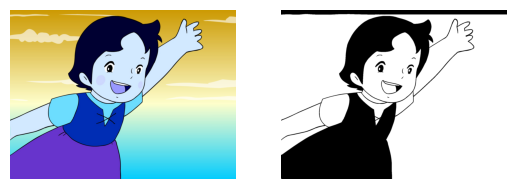

In [21]:

import matplotlib.pyplot as plt
import cv2
d=cv2.imread(r"C:\Users\hanal\Downloads\heidi_01.jpg")

def th(img, n):
    img_shape = img.shape
    height = img_shape[0]
    width = img_shape[1]
    for row in range(width):
        for column in range(height):
            if img[column, row] > n:
                img[column, row] = 255
            else:
                img[column, row] = 0
    return img

i=cv2.cvtColor(d,cv2.COLOR_BGR2GRAY)
fi=th(i,120)
plt.subplot(121)
plt.imshow(d)
plt.axis('off')
plt.subplot(122)
plt.imshow(fi,cmap='gray')
plt.axis('off')

KMEANS

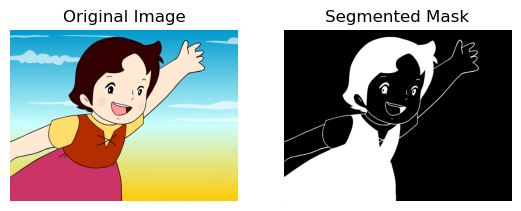

In [19]:
import numpy as np
# Load image
image =cv2.imread(r"C:\Users\hanal\Downloads\heidi_01.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
(h, w, c) = image.shape

# Reshape image into a 2D array of pixels
pixels = image.reshape(-1, 3)  # Shape: (num_pixels, 3)

# K-Means parameters
K = 2  # Number of clusters
max_iters = 10  # Number of iterations
np.random.seed(42)

# Step 1: Initialize Centroids Randomly
random_indices = np.random.choice(pixels.shape[0], K, replace=False)
centroids = pixels[random_indices]  # Pick K random pixels as initial centroids

# Step 2-5: Iterate and refine centroids
for _ in range(max_iters):
    # Compute distances of all pixels to each centroid
    distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)  # Euclidean distance

    # Assign each pixel to the nearest centroid
    labels = np.argmin(distances, axis=1)

    # Update centroids (mean of assigned points)
    new_centroids = np.array([pixels[labels == i].mean(axis=0) for i in range(K)])

    # If centroids do not change, stop
    if np.all(centroids == new_centroids):
        break
    centroids = new_centroids

# Reshape labels to original image shape
segmented_image = labels.reshape(h, w)

# Convert to binary mask (Segmenting only one cluster)
mask = (segmented_image == 1).astype("uint8") * 255

# Apply mask to original image
segmented_output = cv2.bitwise_and(image, image, mask=mask)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(segmented_image, cmap="gray")
plt.title("Segmented Mask")
plt.axis('off')



plt.show()


MEANSHIFT

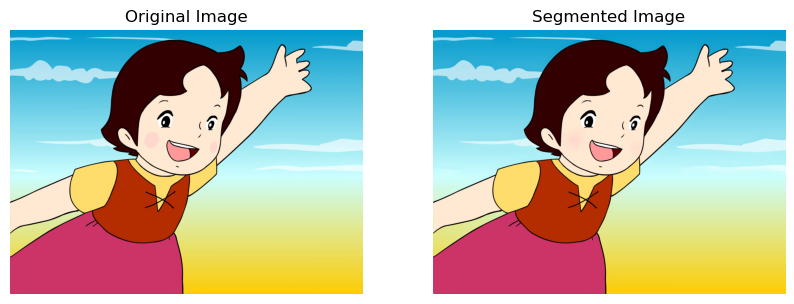

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(r"C:\Users\hanal\Downloads\heidi_01.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply Mean Shift filtering
segmented_image = cv2.pyrMeanShiftFiltering(image, sp=25, sr=30)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.axis('off')

plt.show()

GRAPH CUT

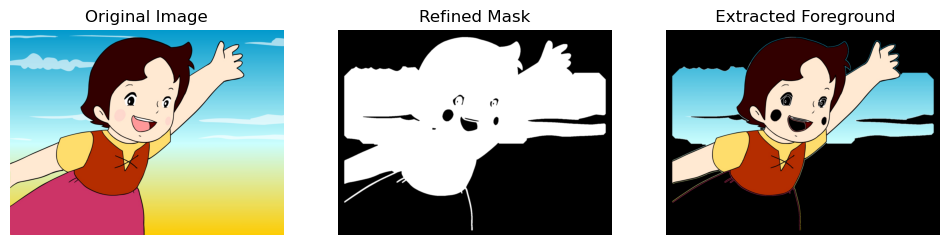

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(r"C:\Users\hanal\Downloads\heidi_01.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 1: Create an initial mask
mask = np.zeros(image.shape[:2], np.uint8)

# Define background and foreground models for GrabCut
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Step 2: Define a rectangle around the object (adjust as needed)
height, width = image.shape[:2]
rect = (40, 20, width - 80, height - 50)  # Adjust to include full subject

# Step 3: Apply GrabCut algorithm with mask refinement
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)

# Step 4: Convert mask to binary (foreground = 1, background = 0)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
# Step 5: Morphological Operations for refinement
kernel = np.ones((3, 3), np.uint8)
mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel, iterations=3)  # Fill small holes
mask2 = cv2.dilate(mask2, kernel, iterations=2)  # Expand foreground

# Step 6: Apply Gaussian blur to smooth edges
mask2 = cv2.GaussianBlur(mask2.astype("float32"), (5, 5), 0)

# Step 7: Apply mask to extract the foreground
result = image * mask2[:, :, np.newaxis]

# Display results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask2, cmap="gray")
plt.title("Refined Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result.astype("uint8"))
plt.title(" Extracted Foreground")
plt.axis('off')

plt.show()


REGION GROWING

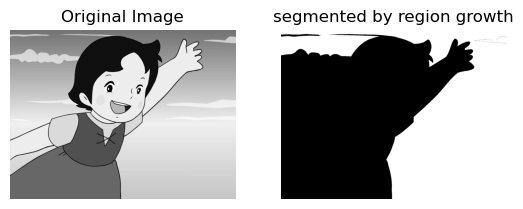

In [24]:


def region(image, seed, threshold):
    rows, cols = image.shape
    segmented_image = np.zeros_like(image)


    segmented_image[seed] = 255

    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    to_process = [seed]

    while to_process:
        current_pixel = to_process.pop()
        x, y = current_pixel

        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy

            if 0 <= nx < rows and 0 <= ny < cols:
                if segmented_image[nx, ny] == 0:
                    if abs(int(image[x, y]) - int(image[nx, ny])) <= threshold:
                        segmented_image[nx, ny] = 255
                        to_process.append((nx, ny))

    return segmented_image


d=cv2.imread(r"C:\Users\hanal\Downloads\heidi_01.jpg")
image_gray = cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)

seed = (7, 7)
threshold = 10


segmented_image = region(image_gray, seed, threshold)


plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title("segmented by region growth")
plt.axis("off")

plt.show()